# Summary

ogs6py is a Python interface for the OpenGeoSys finite element software [@Bilke2019].
In conjunction with VTUinterface it is possible to streamline modeling workflows
in Jupyter Notebooks using Python.
With this article, we wish to introduce two new Python modules that facilitate
the pre- and postprocessing of finite element calculations of OpenGeoSys and thus
make this code more accessible. Their use is demonstrated along workflows typically
encountered by the modeller, including the variation of parameters, boundary conditions,
or solver settings, the verification of simulation results by comparison to analytical
solutions, the set-up and evaluation of ensemble runs, the analysis of results by line plots,
time series, or transient contour plots.

# Statement of need

Driven by its ease-of-use and flexibility as an open-source 
dynamic language, its vast modular ecosystem, the development of powerful plotting
libraries and the Jupyter Notebook technology, Python became the quasi-standard for 
scientific data analysis in the modelling community during the past decade.
However, the attractiveness of Phython is not just limited to postprocessing. 
E.g, with the Python wrapper for GMSH [@geuzaine2009gmsh] or the tool meshio [@nico_schlomer_2021_4745399] also pre-processing tasks can
be easily conducted without leaving the IPython command prompt. The useability of a modeling package
is therefore greatly enhanced if Python bindings are provided. In fact, 
while many open-source tools effectively forced the user to learn a singular syntax
for interacting with the software, Python bindings allow control over such tools from 
within the Python world and thus open them up for a wider community of users.

Here, we are particularly addressing the open-source code OpenGeoSys (OGS) [@Bilke2019] version 6. It is our aim
to facilitate both pre- and post-processing workflows using the Python ecosystem. 
This aim was not the least inspired by the desire to facilitate setting up, controlling and
evaluating ensemble runs [@Buchwald2020,@Chaudhry2021] but has now taken on a wider perspective of general 
software usability. There exists already a similar python interface "ogs5py" for OGS version 5 [@muller2021ogs5py]. 
However, the differences in many concepts, like input file handling, required an entirely new package build from scratch.

As standard output format, OpenGeoSys uses VTK unstructured grid files (VTU) as timeslices stacked together by a PVD file.
These can be analyzed typically using Paraview [@ahrens2005paraview]. For interactive Python use the Python 
wrapper for VTK [@schroeder2000visualizing] and some other tools like PyVista [@sullivan2019pyvista] or Mayavi [@ramachandran2011mayavi] 
are available facilitating an easier access to the VTK library.
While the direct use of the VTK library is quite cumbersome for quite _simple_ tasks, like reading data for a given point set, especially when interpolation between grid points is also required. The latter packages focus mainly on 3D visualization. However, the _bread and butter_ bussiness of a finite-element-modeller often cosists of the extraction of single- or multiple point time-series data.
To our knowledge the named packages (with the exception of Paraview) don't have file support for PVDs or time series data, yet ([@pvdissue; @timeseriesissue].

# Usage

With ogs6py it is possible to create complete OGS source files from scratch or to alter existing file.
The following example uses a complete input file for a coupled THM point heat source problem, exchanges parts and writes the input, runs the problem and analyses the results. We start by importing the modules required for handling OGS input, VTU output mathematical manipulations and plotting.

In [47]:
from ogs6py.ogs import OGS

In [48]:
import plot_settings

In [49]:
import vtuIO

In [50]:
import numpy as np

In [51]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Example problem

In order to demonstrate the features of the problem, we study the example of a tunnel excavation followed by emplacement of a heat-emitting canister. The model simulates the thermal, hydraulic and mechanical response of the system during these two phases. For details on such problems we refer the reader to previous work [@Wang2021]. The modelling domain consists of a $200\; \text{m} \times 200\; \text{m}$ section through a clay rock formation with circular excavatio ($r=2.5\ \text{m}$) with boundary conditions mimicing a heat-emitting canister as can be seen later in the results.

## 1. Excavation


We first excavate the tunnel by gradually reducing the traction and the pore pressure at the tunnel contour.
This is achieved by a so-called deconfinement curve distributing the excavation over 8 days. The excavated tunnel is then left to drain and consolidate for another 300 days prior to the commencement of heating. The excavation phase is set up based on a basic input file provided by the user.

In [52]:
model = OGS(INPUT_FILE="tunnel_ogs6py.prj", PROJECT_FILE="tunnel_exc.prj", MKL=True)

In [53]:
model.replace_text("tunnel_exc", xpath="./time_loop/output/prefix")

In [54]:
model.write_input()

True

The input file tunnel_ogspy.prj can be build from scratch using ogs6py commands. The corresponding code can be found in create_tunnel.py.
The path to the ogs executable and a name for the logfile containing important information on the simulation run need to be given as well.

In [55]:
model.run_model(path="~/github/ogs/build_mkl/bin", logfile="excavation.log")

OGS finished with project file tunnel_exc.prj.
Execution took 32.865978717803955 s


The ouput can be eaysily analyzed using the capabilities of the VTUinterface tool.
It is important to tell vtuIO the dimensionality of the problem in order to use the correct algorithm for spatial interpolation.

One of the most significant features of VTUinterface is the ability to deal with PVD files as time series data.

In [56]:
pvdfile = vtuIO.PVDIO("tunnel_exc.pvd", dim=2)

tunnel_exc.pvd


The folllowing command reads time series data from the PVD and the VTU files referenced therein.
The default observation point is {'pt0': (0,0,0)} corresponding to the tunnel center. Using the interpolation method nearest,
the data at the tunnel boundary can be gathered:

In [57]:
excavation_curve = pvdfile.read_time_series("pressure", interpolation_method="nearest")

and directly displayed using matplotlib:

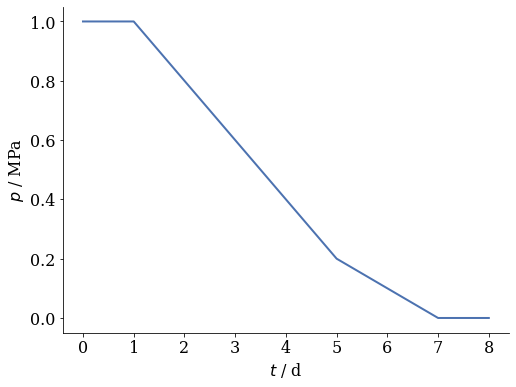

In [58]:
plt.plot(pvdfile.timesteps, excavation_curve["pt0"] / 1e6)
plt.xlabel("$t$ / d")
plt.ylabel("$p$ / MPa");

## 2. Spatially varying properties

Another useful feature in a modelling workflow we wish to demonstrate is the assignment of spatially varying properties, initial conditions, etc. Here, we include a permeability enhancement in the vicinity of the tunnel after excavation in order to mimic the existence of an excavation damaged zone (EDZ) as an illustrative example [@Wang2021]. Counter to our usual simulations, the EDZ is here only activated in the heating phase in order to keep this demonstration case simple.

To define a field for an existing VTU file, we can define an arbitrary founction depending on three coordinates x,y and z:

In [59]:
R = 2.5

In [60]:
def permEDZ(x,y,z):
    r = np.sqrt(x**2+y**2)
    return np.exp(-(r-R)*3)/1e17+1e-20

In [61]:
r = np.linspace(R,10,100)

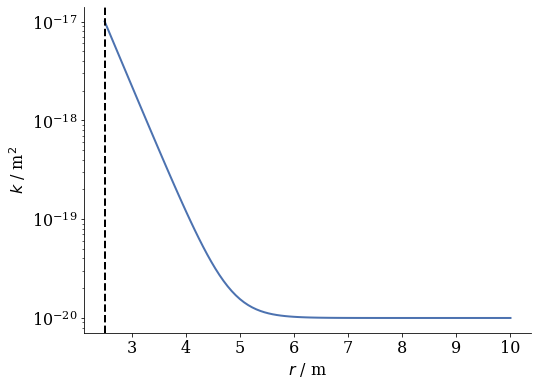

In [62]:
plt.plot(r,permEDZ(r,0,0))
plt.axvline(R,ls='--',color='black')
plt.xlabel("$r$ / m")
plt.yscale("log")
plt.ylabel("$k$ / m$^2$");

We read in the last time-step after the excavation:

In [63]:
lasttimestep = vtuIO.VTUIO("tunnel_exc_ts_81_t_8.000000.vtu", dim=2)

The function ist then converted to a point field which is transformed to cell data by the function argument cell=True and written to the file "tunnel_restart.vtu":

In [64]:
lasttimestep.func_to_field(permEDZ, "perm", "tunnel_restart.vtu", cell=True)

## 3. Heating phase

Now that the properties are set and the initial conditions calculated, we can start the heating simulation. The following input specifies the boundary conditions of the problem and the material properties in the input file for the new phase, which is also based on the original input file used above for the excavation run.

The following set of methods are general purpose methods specially suited for manipulating the OGS-6 (XML) input.

In [65]:
model = OGS(INPUT_FILE="tunnel.prj", PROJECT_FILE="tunnel_heat.prj", MKL=True)

In [66]:
model.replace_text("tunnel_restart.vtu", xpath="./meshes/mesh", occurrence=0)
model.replace_text("tunnel_heat", xpath="./time_loop/output/prefix")
model.remove_element("./processes/process/initial_stress")
model.remove_element("./media/medium/properties/property[name='permeability']")
model.remove_element("./parameters/parameter[mesh='tunnel']")
model.add_block("property", parent_xpath="./media/medium/properties", taglist=["name","type", "parameter_name"], textlist=["permeability", "Parameter", "k"])
model.add_block("parameter", parent_xpath="./parameters", taglist=["name","type", "field_name"], textlist=["k", "MeshElement", "perm"])
model.add_block("parameter", parent_xpath="./parameters", taglist=["name","type", "field_name"], textlist=["displacement_exc", "MeshNode", "displacement"])
model.add_block("parameter", parent_xpath="./parameters", taglist=["name","type", "field_name"], textlist=["pressure_exc", "MeshNode", "pressure"])
model.replace_text("displacement_exc", xpath="./process_variables/process_variable[name='displacement']/initial_condition")
model.replace_text("pressure_exc", xpath="./process_variables/process_variable[name='pressure']/initial_condition")
model.remove_element("./process_variables/process_variable[name='displacement']/boundary_conditions/boundary_condition[mesh='tunnel_inner']")
model.remove_element("./process_variables/process_variable[name='pressure']/boundary_conditions/boundary_condition[mesh='tunnel_inner']")
model.add_block("boundary_condition", parent_xpath="./process_variables/process_variable[name='temperature']/boundary_conditions", taglist=["mesh","type", "parameter"], textlist=["tunnel_inner", "Neumann", "heat_bc"])
model.replace_text("100000000", xpath="./time_loop/processes/process/time_stepping/t_end")
model.replace_text("500000", xpath="./time_loop/processes/process/time_stepping/initial_dt")
model.replace_text("50000", xpath="./time_loop/processes/process/time_stepping/minimum_dt")
model.replace_text("500000", xpath="./time_loop/processes/process/time_stepping/maximum_dt")
model.replace_text("10", xpath="./time_loop/output/timesteps/pair/each_steps")

In [67]:
model.write_input()

True

In [68]:
model.run_model(path="~/github/ogs/build_mkl/bin", logfile="heating.log")

OGS finished with project file tunnel_heat.prj.
Execution took 135.33820176124573 s


We now look at the output again and define a set of observation points. We're interested in temperatures as well as pore pressure rise due to thermal pressurization of the fluid.

In [69]:
pvdfile = vtuIO.PVDIO("tunnel_heat.pvd", dim=2)

tunnel_heat.pvd


In [70]:
pts = {"pt0": (3.5,3.5,0), "pt1": (5.5,5.5,0), "pt2": (8.5,8.5,0)}

In [71]:
heating_curve = pvdfile.read_time_series("temperature", pts=pts)
pressure_curve = pvdfile.read_time_series("pressure", pts=pts)

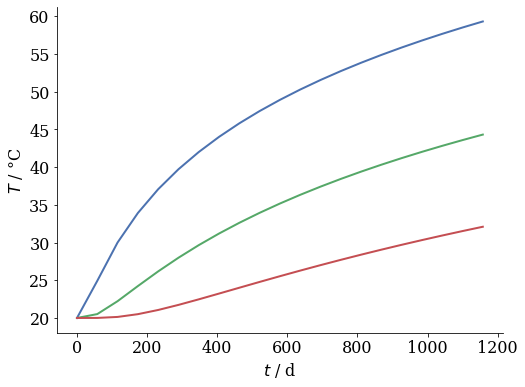

In [72]:
for pt in pts:
    plt.plot(pvdfile.timesteps/86400, heating_curve[pt]-273.15)
plt.xlabel("$t$ / d")
plt.ylabel("$T$ / °C");

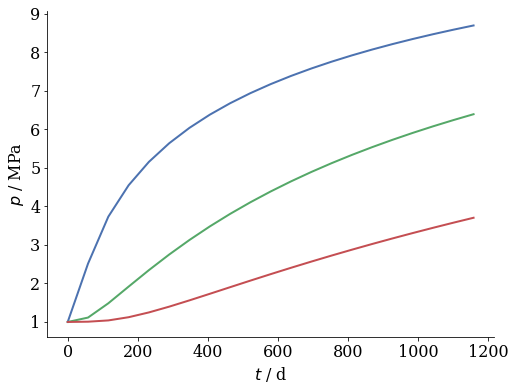

In [73]:
for pt in pts:
    plt.plot(pvdfile.timesteps/86400, pressure_curve[pt] / 1e6)
plt.xlabel("$t$ / d")
plt.ylabel("$p$ / MPa");
#plt.xscale('log')

In [74]:
last_ts_vtu = vtuIO.VTUIO(pvdfile.vtufilenames[-1], dim=2)

Without interpolation any field corresponding to the order of node points (saved in .points variable) can be read with the following command.

In [75]:
pressurefield = last_ts_vtu.get_point_field("pressure_interpolated")

The available field names can be obtained as well using the following function call:

In [76]:
last_ts_vtu.get_point_field_names()

['HydraulicFlow',
 'NodalForces',
 'displacement',
 'epsilon',
 'original_node_number',
 'pressure',
 'pressure_interpolated',
 'saturation',
 'sigma',
 'temperature',
 'temperature_interpolated',
 'velocity']

To make a contour plot of the pressure field, matplotlibs triangulation tools can be used:

In [77]:
levels = np.arange(1, 10, 0.5)

In [78]:
triang = tri.Triangulation(last_ts_vtu.points[:,0],last_ts_vtu.points[:,1])

In [79]:
triang.set_mask(np.hypot(last_ts_vtu.points[:,0][triang.triangles].mean(axis=1),
                         last_ts_vtu.points[:,1][triang.triangles].mean(axis=1))
                < R)

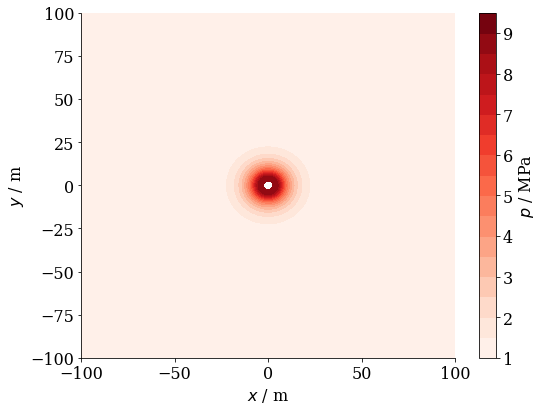

In [80]:
plt.tricontourf(triang,pressurefield/1e6, cmap=plt.cm.get_cmap("Reds"), levels=levels)
plt.xlabel("$x$ / m")
plt.ylabel("$y$ / m")
plt.colorbar(label='$p$ / MPa')
plt.tight_layout()

Often it is important to read out data at arbitraty points within the mesh or along predefined lines.
To do that we need to interpolate between grid points.
VTUinterface uses scipy.interpolate for interpolation between grid points, i.e., the user can select between different methods that are provided by scipy.interpolate.

A diagonal point set can be defined as follows:

In [81]:
x = np.linspace(R,50,num=100)

In [82]:
diagonal = [(i,i,0) for i in x]

In [83]:
interp_methods = ["nearest", "linear", "cubic"]

Using three different interpolation methods, we can read the output data for a point set array along the diagonal.

In [84]:
p_diagonal = {}
for method in interp_methods:
    p_diagonal[method] = last_ts_vtu.get_point_set_data("pressure_interpolated", pointsetarray=diagonal, interpolation_method=method)

In [85]:
r = np.sqrt(2*x*x)

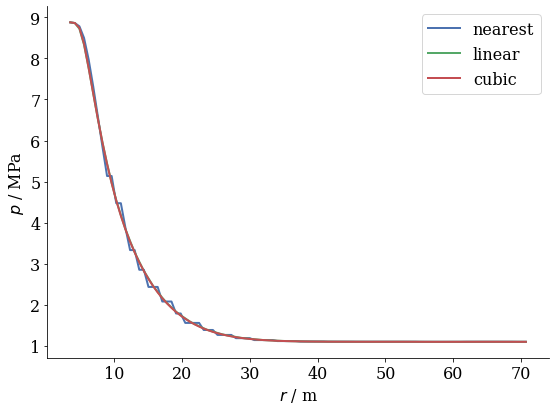

In [86]:
for method in interp_methods:
    plt.plot(r[:],p_diagonal[method]/1e6, label=method)
plt.legend()
plt.xlabel("$r$ / m")
plt.ylabel("$p$ / MPa")
plt.tight_layout();

## 5. Ensemble runs, sensitivity studies

The combination of ogs6py with VTUinterface allows us to perform ensemble runs quite easily and to analyze the results directly on-the-fly.
E.g., considering a  distribution of a triangularly distributed parameter like the solid thermal expansion coefficient $a_\text{s}$:

In [87]:
a_s_dist = {"low": 1e-6, "mid": 1.e-5, "high": 1.5e-5} 

In contrast to the the general purpose methods like `replace_text()` and `add_block()`, there exist also methods for very conveniently replacing medium, phase and parameter properties.
In this example we use `replace_phase_property()` to set the solid thermal expansion coefficient drawn from the given distribution in each iteration.
After execution, the pressure value at given points is read for the last time step and saved into a list.
Parallelization of these kind of ensemble run is straight forwad e.g., using Pythons concurrent future methods.

In [88]:
a_s = []
pressure = []
for i in range(5):
    model = OGS(INPUT_FILE="tunnel_heat.prj", PROJECT_FILE="tunnel_heat_sample.prj", MKL=True)
    a_s.append(np.random.triangular(a_s_dist["low"], a_s_dist["mid"],a_s_dist["high"]))
    model.replace_text("tunnel_heat_sample", xpath="./time_loop/output/prefix")
    model.replace_phase_property(mediumid=0, phase="Solid", name="thermal_expansivity", value=a_s[-1])
    model.write_input()
    model.run_model(path="~/github/ogs/build_mkl/bin", logfile="heating.log")
    pvd = vtuIO.PVDIO("tunnel_heat_sample.pvd")
    last_ts_vtu = vtuIO.VTUIO(pvd.vtufilenames[-1], dim=2)
    p_data = last_ts_vtu.get_point_data("pressure_interpolated", pts=pts)
    pressure.append(p_data["pt2"])

OGS finished with project file tunnel_heat_sample.prj.
Execution took 138.44093585014343 s
tunnel_heat_sample.pvd
OGS finished with project file tunnel_heat_sample.prj.
Execution took 139.1070053577423 s
tunnel_heat_sample.pvd
OGS finished with project file tunnel_heat_sample.prj.
Execution took 167.14446687698364 s
tunnel_heat_sample.pvd
OGS finished with project file tunnel_heat_sample.prj.
Execution took 166.8939745426178 s
tunnel_heat_sample.pvd
OGS finished with project file tunnel_heat_sample.prj.
Execution took 135.93265199661255 s
tunnel_heat_sample.pvd


The output shows the linear correlation between the thermal expansion coeffient and the pressure response at the giveb point.

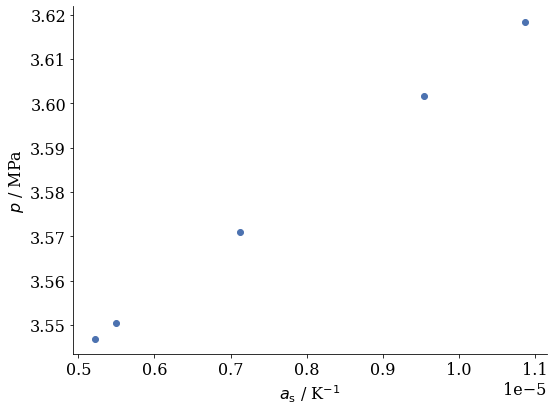

In [89]:
plt.scatter(a_s, np.array(pressure)/1e6)
plt.xlabel('$a_\\mathrm{s}$ / K$^{-1}$')
plt.ylabel('$p$ / MPa')
plt.tight_layout();

## 6. Log-parsing

ogs6py also has a tool for parsing the OGS log output.
This can be very helpful for studying numerical stability and performance.
In the following example the output is read and the number or nonlinear iterations needed for every time step are ploted versus the time steps.

In [188]:
#"heating.log"
out_df = model.parse_out("THM.log")

In [189]:
out_df.drop_duplicates(subset ="time_step/number", keep = "last", inplace = True)

The output shows a very stable behavior as every time step needs 5 or 6 nonlinear iterations to converge.

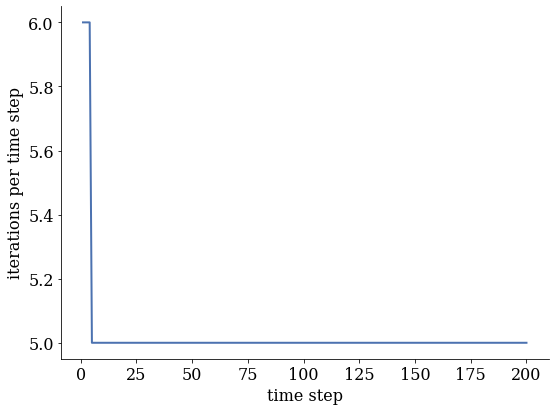

In [190]:
plt.plot(out_df["time_step/number"], out_df["time_step/iteration/number"])
plt.xlabel("time step")
plt.ylabel("iterations per time step")
plt.tight_layout();

In [197]:
out_df = model.parse_out("heating.log")

In [198]:
#out_df["iterations_abs"] = out_df["time_step/number"]*out_df["time_step/iteration/number"]

In [199]:
out_df_new = out_df[out_df["time_step/iteration/component_convergence/number"]==1]

In [200]:
#out_df.drop_duplicates(subset ="iterations_abs", keep = "first", inplace = True)

In [201]:
range(2)

range(0, 2)

In [202]:
out_df_new[out_df_new["time_step/number"]==2]

,execution_time,time_step/number,time_step/t,time_step/dt,time_step/cpu_time,time_step/output_time,time_step/iteration/number,time_step/iteration/assembly_time,time_step/iteration/dirichlet_bc_time,time_step/iteration/linear_solver_time,time_step/iteration/cpu_time,time_step/iteration/phase_field_parameter,time_step/iteration/component_convergence/number,time_step/iteration/component_convergence/dx,time_step/iteration/component_convergence/x,time_step/iteration/component_convergence/dx_relative
25,135.865,2,1000000.0,500000.0,0.754461,NaN,1,0.066218,0.002523,0.050946,0.121924,None,1,7.355000e+06,62188000.0,1.182700e-01
29,135.865,2,1000000.0,500000.0,0.754461,NaN,2,0.065676,0.002613,0.050986,0.121493,None,1,7.289500e+05,61781000.0,1.179900e-02
33,135.865,2,1000000.0,500000.0,0.754461,NaN,3,0.065642,0.002537,0.050389,0.120828,None,1,4.140300e+01,61781000.0,6.701600e-07
37,135.865,2,1000000.0,500000.0,0.754461,NaN,4,0.065741,0.002510,0.050918,0.121393,None,1,3.219100e+00,61781000.0,5.210500e-08
41,135.865,2,1000000.0,500000.0,0.754461,NaN,5,0.065670,0.002549,0.050473,0.120953,None,1,2.173800e-04,61781000.0,3.518500e-12
45,135.865,2,1000000.0,500000.0,0.754461,NaN,6,0.066104,0.002565,0.050619,0.121478,None,1,1.412500e-05,61781000.0,2.286300e-13


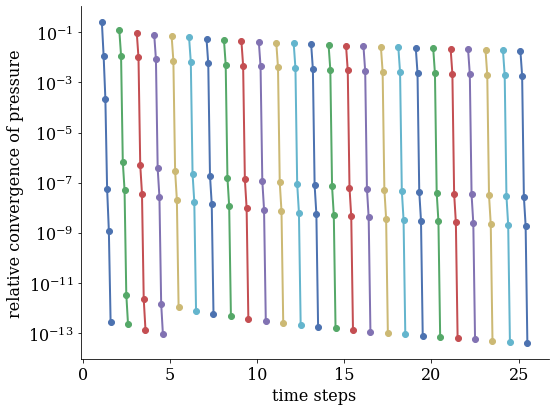

In [203]:
for i in range(25):
    plt.plot(out_df_new[out_df_new["time_step/number"]==i+1]["time_step/number"]+0.1*out_df_new[out_df_new["time_step/number"]==i+1]["time_step/iteration/number"],out_df_new[out_df_new["time_step/number"]==i+1]["time_step/iteration/component_convergence/dx_relative"],'-o')
plt.xlabel("time steps")
plt.ylabel("relative convergence of pressure")
plt.yscale('log')
plt.tight_layout();

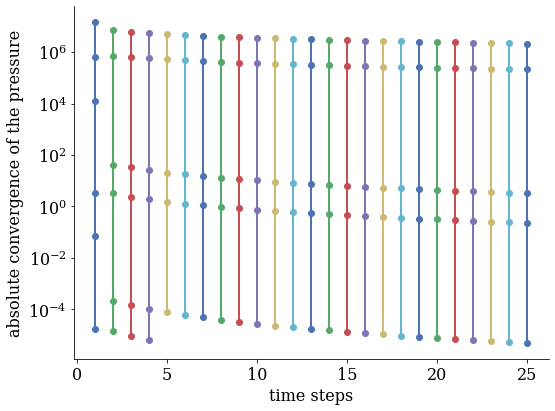

In [204]:
for i in range(25):
    plt.plot(out_df_new[out_df_new["time_step/number"]==i+1]["time_step/number"],out_df_new[out_df_new["time_step/number"]==i+1]["time_step/iteration/component_convergence/dx"],'-o')
plt.xlabel("time steps")
plt.ylabel("absolute convergence of the pressure")
plt.yscale('log')
plt.tight_layout();

# Conclusions

A short overview over the capabilities of ogs6py and VTUinterface for enhancing modeling workflows in OpenGeoSys was presented.
There is no limit to the user's creativity in applying these tools to more complex situations. For the sake of brevity, we focused
on highlight relevant in most modeling studies.